# Deep Learning with TensorFlow/Keras

Now that we have completed a project of Machine Learning with spark ML, in this assignment, we will be swithing to the context of Deep Learning with Tensorflow/Keras by two tasks:
- Task1: Image Classification with CNN
- Task2: Image captioning with a combination of CNN and RNN

## Task 1: Going Deeper with convolutions


Before **Inception v1** (**GoogLeNet**), which is the winner of the **ILSVRC** (ImageNet Large Scale Visual Recognition Competition) in 2014, most popular CNNs just stacked convolution layers deeper and deeper, hoping to get better performance.
The Inception network, however, uses a lot of tricks to improve performance in terms of speed and accuracy.
Compared to other networks, **Inception v1** has significant improvement over **ZFNet** (the winner in 2013) and **AlexNet** (the winner in 2012), and has relatively lower error rate compared with the VGGNet.

In this task, we will be implementing the inception architecture [in this paper](https://arxiv.org/abs/1409.4842) with TensorFlow/Keras. 

The goal of this task is to understand how to write code to build the model, as long as you can verify the correctness of the code (e.g., through Keras model summary), it is not necessary to train the model.

In [89]:
# This implementation of LRN (code cell) has been copied from https://gist.github.com/joelouismarino/a2ede9ab3928f999575423b9887abd14
# Local Response Normalization has been removed from Keras and thus we decided to use this function

from keras.layers.core import Layer
from keras import backend as K
if K.backend() == 'theano':
    import theano.tensor as T
elif K.backend() == 'tensorflow':
    import tensorflow as tf
else:
    raise NotImplementedError


class LRN(Layer):

    def __init__(self, alpha=0.0001, k=1, beta=0.75, n=5, **kwargs):
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n
        super(LRN, self).__init__(**kwargs)

    def call(self, x, mask=None):
        b, ch, r, c = x.shape
        half_n = self.n // 2 # half the local region
        input_sqr = K.square(x) # square the input
        if K.backend() == 'theano':
            # make an empty tensor with zero pads along channel dimension
            zeros = T.alloc(0., b, ch + 2*half_n, r, c)
            # set the center to be the squared input
            input_sqr = T.set_subtensor(zeros[:, half_n:half_n+ch, :, :], input_sqr)
        else:
            input_sqr = tf.pad(input_sqr, [[0, 0], [half_n, half_n], [0, 0], [0, 0]])
        scale = self.k # offset for the scale
        norm_alpha = self.alpha / self.n # normalized alpha
        for i in range(self.n):
            scale += norm_alpha * input_sqr[:, i:i+ch, :, :]
        scale = scale ** self.beta
        x = x / scale
        return x

    def get_config(self):
        config = {"alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [90]:
import tensorflow as tf
import numpy as np
import keras

from keras.models import Model
from keras.layers import Input, Flatten, ZeroPadding2D, Concatenate, Dense, Conv2D, MaxPool2D, AvgPool2D, Dropout, Activation
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

print(tf.__version__)
print(keras.__version__)

2.0.0-beta1
2.3.1


In [192]:
# Input, pictures 224x224 RGB
input = Input(shape=(224, 224, 3), name='input')

# Convolution 7x7/2 
conv1_7x7_2 = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu', name='conv1_7x7_2')(input)

# Max pool 3x3/2
max_pool1_3x3_2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='max_pool1_3x3_2')(conv1_7x7_2)

# Normalization
pool1_norm = LRN(name='pool1_norm')(max_pool1_3x3_2)

# Reduce filter
conv2_reduce = Conv2D(64, (1,1), padding='same', activation='relu', name='conv2_3x3_reduce')(pool1_norm)

# Convolution 3x3/1
conv2_3x3_1 = Conv2D(192, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv2_3x3_1')(conv2_reduce)

# Normalization
pool2_norm = LRN(name='pool2_norm')(conv2_3x3_1)

# Max pool 3x3/2
max_pool2_3x3_2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='max_pool2_3x3_2')(pool2_norm)

In [215]:
# Inception 3a
conv3a_1x1 = Conv2D(64, (1, 1), padding='same', activation='relu', name='inception3a_1x1')(max_pool2_3x3_2) 

reduce3a_3x3 = Conv2D(96, (1, 1), padding='same', activation='relu', name='inception3a_reduce_3x3')(max_pool2_3x3_2)
conv3a_3x3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='inception3a_3x3')(reduce3a_3x3)

reduce3a_5x5 = Conv2D(16, (1, 1), padding='same', activation='relu', name='inception3a_reduce_5x5')(max_pool2_3x3_2)
conv3a_5x5 = Conv2D(32, (5, 5), padding='same', activation='relu', name='inception3a_5x5')(reduce3a_5x5)

pool3a_3x3 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='inception3a_pool_3x3')(max_pool2_3x3_2)
proj_pool3a = Conv2D(32, (1, 1), padding='same', activation='relu', name='inception3a_pool_proj')(pool3a_3x3)

output3a = Concatenate(axis=3, name='inception3a_output')([conv3a_1x1,
                                                           conv3a_3x3,
                                                           conv3a_5x5,
                                                           proj_pool3a
                                                          ])

In [232]:
# Inception (3b)
conv3b_1x1 = Conv2D(128, (1, 1), padding='same', activation='relu', name='inception3b_1x1')(output3a)

reduce3b_3x3 = Conv2D(128, (1, 1), padding='same', activation='relu', name='inception3b_reduce_3x3')(output3a)
conv3b_3x3 = Conv2D(192, (3, 3), padding='same', activation='relu', name='inception3b_3x3')(reduce3b_3x3)

reduce3b_5x5 = Conv2D(32, (1, 1), padding='same', activation='relu', name='inception3b_reduce_5x5')(output3a)
conv3b_5x5 = Conv2D(96, (5, 5), padding='same', activation='relu', name='inception3b_5x5')(reduce3b_5x5)

pool3b_3x3 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='inception3b_pool_3x3')(output3a)
proj_pool3b = Conv2D(64, (1, 1), padding='same', activation='relu', name='inception3b_pool_proj')(pool3b_3x3)

output3b = Concatenate(axis=3, name='inception3b_output')([conv3b_1x1,
                                                           conv3b_3x3,
                                                           conv3b_5x5,
                                                           proj_pool3b
                                                          ])

In [217]:
# Max pool 3x3/2
max_pool3_3x3_2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='max_pool3_3x3_2')(output3b)


In [239]:
# Inception (4a)
conv4a_1x1 = Conv2D(192, (1, 1), padding='same', activation='relu', name='inception4a_1x1')(max_pool3_3x3_2) 

reduce4a_3x3 = Conv2D(96, (1, 1), padding='same', activation='relu', name='inception4a_reduce_3x3')(max_pool3_3x3_2)
conv4a_3x3 = Conv2D(208, (3, 3), padding='same', activation='relu', name='inception4a_3x3')(reduce4a_3x3)

reduce4a_5x5 = Conv2D(16, (1, 1), padding='same', activation='relu', name='inception4a_reduce_5x5')(max_pool3_3x3_2)
conv4a_5x5 = Conv2D(48, (5, 5), padding='same', activation='relu', name='inception4a_5x5')(reduce4a_5x5)

pool4a_3x3 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='inception4a_pool_3x3')(max_pool3_3x3_2)
proj_pool4a = Conv2D(64, (1, 1), padding='same', activation='relu', name='inception4a_pool_proj')(pool4a_3x3)

output4a = Concatenate(axis=3, name='inception4a_output')([conv4a_1x1,
                                                           conv4a_3x3,
                                                           conv4a_5x5,
                                                           proj_pool4a
                                                          ])

In [359]:
# Output from 4a inception

# Avg pool 7x7/1
avg_pool4a_7x7_1 = AvgPool2D(pool_size=(5, 5), strides=(3, 3), padding='same', name='avg_pool4a_7x7_1')(output4a)

# Reduce layer
reduce_output4a = Conv2D(128, (1, 1), padding='same', activation='relu', name='reduce_output4a')(avg_pool4a_7x7_1)

# Fully connected layer
fc_output4a = Dense(1024, name='fc_output4a')(reduce_output4a)

# Dropout
dropout_output4a = Dropout(0.7)(fc_output4a)

# Linear classifier
linear_classifier_output4a = Dense(1000, name='linear_output4a')(dropout_output4a)

# Softmax
softmax4a = Activation('softmax', name='prob_output4a')(linear_classifier_output4a)

In [346]:
# Inception (4b)
conv4b_1x1 = Conv2D(160, (1, 1), padding='same', activation='relu', name='inception4b_1x1')(output4a) 

reduce4b_3x3 = Conv2D(112, (1, 1), padding='same', activation='relu', name='inception4b_reduce_3x3')(output4a)
conv4b_3x3 = Conv2D(224, (3, 3), padding='same', activation='relu', name='inception4b_3x3')(reduce4b_3x3)

reduce4b_5x5 = Conv2D(24, (1, 1), padding='same', activation='relu', name='inception4b_reduce_5x5')(output4a)
conv4b_5x5 = Conv2D(64, (5, 5), padding='same', activation='relu', name='inception4b_5x5')(reduce4b_5x5)

pool4b_3x3 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='inception4b_pool_3x3')(output4a)
proj_pool4b = Conv2D(64, (1, 1), padding='same', activation='relu', name='inception4b_pool_proj')(pool4b_3x3)

output4b = Concatenate(axis=3, name='inception4b_output')([conv4b_1x1,
                                                           conv4b_3x3,
                                                           conv4b_5x5,
                                                           proj_pool4b
#                                                            avg_pool4a_7x7_1_pad
                                                          ])

In [347]:
# Inception (4c)
conv4c_1x1 = Conv2D(128, (1, 1), padding='same', activation='relu', name='inception4c_1x1')(output4b) 

reduce4c_3x3 = Conv2D(128, (1, 1), padding='same', activation='relu', name='inception4c_reduce_3x3')(output4b)
conv4c_3x3 = Conv2D(256, (3, 3), padding='same', activation='relu', name='inception4c_3x3')(reduce4c_3x3)

reduce4c_5x5 = Conv2D(24, (1, 1), padding='same', activation='relu', name='inception4c_reduce_5x5')(output4b)
conv4c_5x5 = Conv2D(64, (5, 5), padding='same', activation='relu', name='inception4c_5x5')(reduce4c_5x5)

pool4c_3x3 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='inception4c_pool_3x3')(output4b)
proj_pool4c = Conv2D(64, (1, 1), padding='same', activation='relu', name='inception4c_pool_proj')(pool4c_3x3)

output4c = Concatenate(axis=3, name='inception4c_output')([conv4c_1x1,
                                                           conv4c_3x3,
                                                           conv4c_5x5,
                                                           proj_pool4c
                                                          ])

In [368]:
# Inception (4d)
conv4d_1x1 = Conv2D(112, (1, 1), padding='same', activation='relu', name='inception4d_1x1')(output4c) 

reduce4d_3x3 = Conv2D(144, (1, 1), padding='same', activation='relu', name='inception4d_reduce_3x3')(output4c)
conv4d_3x3 = Conv2D(288, (3, 3), padding='same', activation='relu', name='inception4d_3x3')(reduce4d_3x3)

reduce4d_5x5 = Conv2D(32, (1, 1), padding='same', activation='relu', name='inception4d_reduce_5x5')(output4c)
conv4d_5x5 = Conv2D(64, (5, 5), padding='same', activation='relu', name='inception4d_5x5')(reduce4d_5x5)

pool4d_3x3 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='inception4d_pool_3x3')(output4c)
proj_pool4d = Conv2D(64, (1, 1), padding='same', activation='relu', name='inception4d_pool_proj')(pool4d_3x3)

output4d = Concatenate(axis=3, name='inception4d_output')([conv4d_1x1,
                                                           conv4d_3x3,
                                                           conv4d_5x5,
                                                           proj_pool4d
                                                          ])

In [369]:
# Output from 4d inception

# Avg pool 7x7/1
avg_pool4d_7x7_1 = AvgPool2D(pool_size=(5, 5), strides=(3, 3), padding='same', name='avg_pool4d_7x7_1')(output4d)

# Reduce layer
reduce_output4d = Conv2D(128, (1, 1), padding='same', activation='relu', name='reduce_output4d')(avg_pool4d_7x7_1)

# Fully connected layer
fc_output4d = Dense(1024, name='fc_output4d')(reduce_output4d)

# Dropout
dropout_output4d = Dropout(0.7)(fc_output4d)

# Linear classifier
linear_classifier_output4d = Dense(1000, name='linear_output4d')(dropout_output4d)

# Softmax
softmax4d = Activation('softmax', name='prob_output4d')(linear_classifier_output4d)

In [370]:
# Inception (4e)
conv4e_1x1 = Conv2D(256, (1, 1), padding='same', activation='relu', name='inception4e_1x1')(output4d) 

reduce4e_3x3 = Conv2D(160, (1, 1), padding='same', activation='relu', name='inception4e_reduce_3x3')(output4d)
conv4e_3x3 = Conv2D(320, (3, 3), padding='same', activation='relu', name='inception4e_3x3')(reduce4e_3x3)

reduce4e_5x5 = Conv2D(32, (1, 1), padding='same', activation='relu', name='inception4e_reduce_5x5')(output4d)
conv4e_5x5 = Conv2D(128, (5, 5), padding='same', activation='relu', name='inception4e_5x5')(reduce4e_5x5)

pool4e_3x3 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='inception4e_pool_3x3')(output4d)
proj_pool4e = Conv2D(128, (1, 1), padding='same', activation='relu', name='inception4e_pool_proj')(pool4e_3x3)

output4e = Concatenate(axis=3, name='inception4e_output')([conv4e_1x1,
                                                           conv4e_3x3,
                                                           conv4e_5x5,
                                                           proj_pool4e
                                                          ])

In [371]:
# Max pool 3x3/2
max_pool4_3x3_2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='max_pool4_3x3_2')(output4e)


In [372]:
# Inception (5a)
conv5a_1x1 = Conv2D(256, (1, 1), padding='same', activation='relu', name='inception5a_1x1')(max_pool4_3x3_2) 

reduce5a_3x3 = Conv2D(160, (1, 1), padding='same', activation='relu', name='inception5a_reduce_3x3')(max_pool4_3x3_2)
conv5a_3x3 = Conv2D(320, (3, 3), padding='same', activation='relu', name='inception5a_3x3')(reduce5a_3x3)

reduce5a_5x5 = Conv2D(32, (1, 1), padding='sameactivation='relu', name='inception5a_reduce_5x5')(max_pool4_3x3_2)
conv5a_5x5 = Conv2D(128, (5, 5), activation='relu', name='inception5a_5x5')(reduce5a_5x5_pad)

pool5a_3x3 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='inception5a_pool_3x3')(max_pool4_3x3_2)
proj_pool5a = Conv2D(128, (1, 1), padding='same', activation='relu', name='inception5a_pool_proj')(pool5a_3x3)

output5a = Concatenate(axis=3, name='inception5a_output')([conv5a_1x1,
                                                           conv5a_3x3,
                                                           conv5a_5x5,
                                                           proj_pool5a
                                                          ])


In [373]:
# Inception (5b)
conv5b_1x1 = Conv2D(384, (1, 1), padding='same', activation='relu', name='inception5b_1x1')(output5a) 

reduce5b_3x3 = Conv2D(192, (1, 1), padding='same', activation='relu', name='inception5b_reduce_3x3')(output5a)
conv5b_3x3 = Conv2D(384, (3, 3), padding='same', activation='relu', name='inception5b_3x3')(reduce5b_3x3)

reduce5b_5x5 = Conv2D(48, (1, 1), activation='relu', name='inception5b_reduce_5x5')(output5a)
reduce5b_5x5_pad = ZeroPadding2D(padding=(2, 2))(reduce5b_5x5)
conv5b_5x5 = Conv2D(128, (5, 5), activation='relu', name='inception5b_5x5')(reduce5b_5x5_pad)

pool5b_3x3 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='inception5b_pool_3x3')(output5a)
proj_pool5b = Conv2D(128, (1, 1), padding='same', activation='relu', name='inception5b_pool_proj')(pool5b_3x3)

output5b = Concatenate(axis=3, name='inception5b_output')([conv5b_1x1,
                                                           conv5b_3x3,
                                                           conv5b_5x5,
                                                           proj_pool5b
                                                          ])

In [378]:
# Avg pool 7x7/1
avg_pool_7x7_1 = AvgPool2D(pool_size=(7, 7), strides=(1, 1), padding='same', name='avg_pool_7x7_1')(output5b)
# avg_pool_7x7_1_flat = Flatten()(avg_pool_7x7_1)

# Dropout (40%)
dropout = Dropout(0.4)(avg_pool_7x7_1)

# Linear
linear_classifier = Dense(1000, name='linear')(dropout)

# Softmax
softmax = Activation('softmax', name='prob')(linear_classifier)

model = Model(inputs=input, outputs=[softmax, softmax4a, softmax4d])

In [379]:
model.compile(optimizer="sgd", loss='categorical_crossentropy')

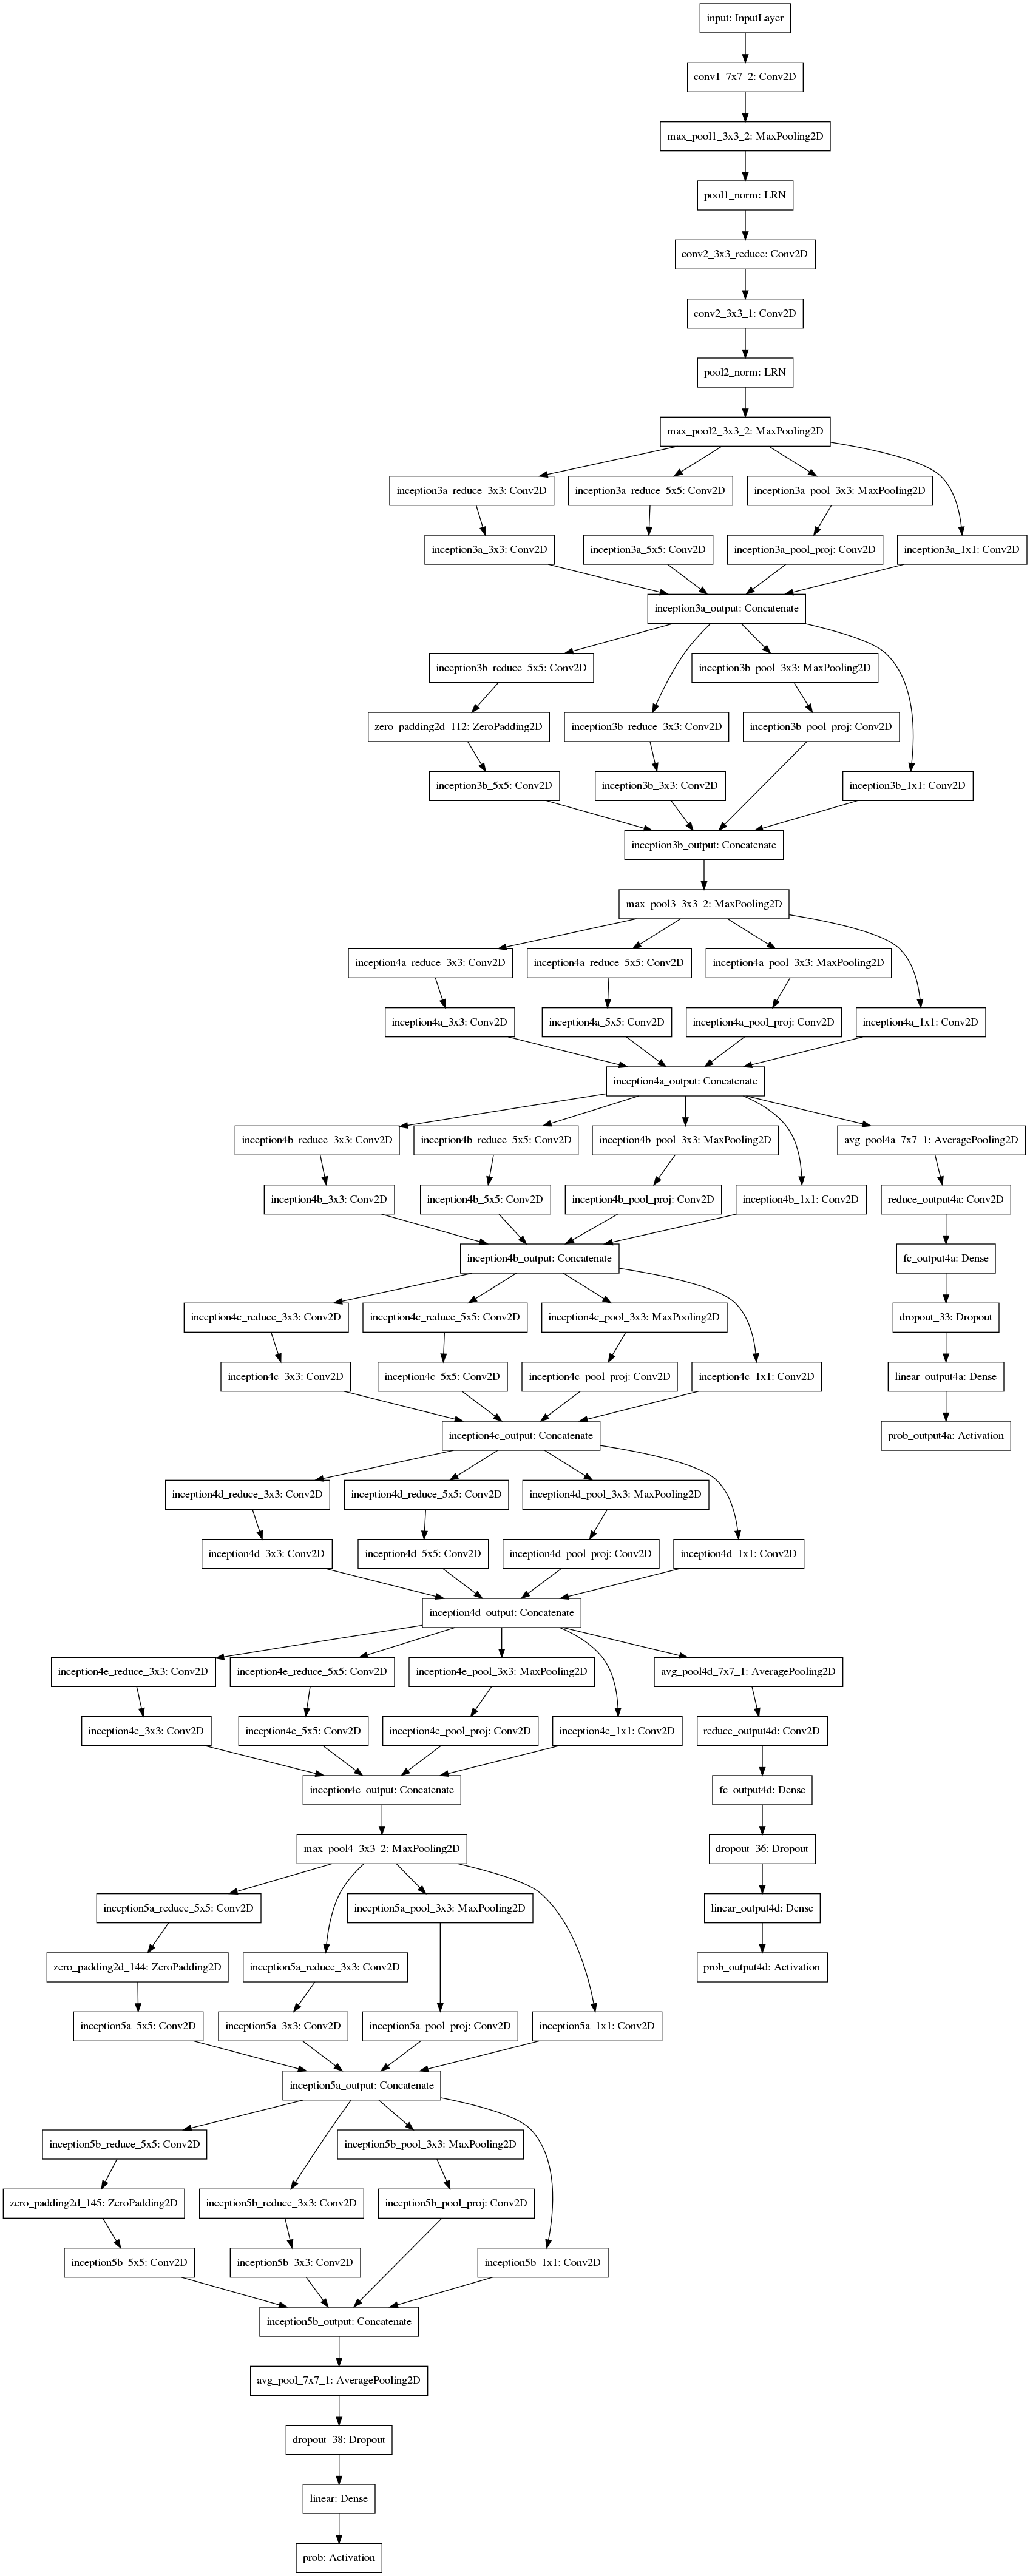

In [380]:
from IPython.display import Image 
 
tf.keras.utils.plot_model(model, show_layer_names=True, to_file='model.png')
Image('model.png')

In [377]:
model.build(input_shape=(224, 224, 3))
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_7x7_2 (Conv2D)            (None, 112, 112, 64) 9472        input[0][0]                      
__________________________________________________________________________________________________
max_pool1_3x3_2 (MaxPooling2D)  (None, 56, 56, 64)   0           conv1_7x7_2[0][0]                
__________________________________________________________________________________________________
pool1_norm (LRN)                (None, 56, 56, 64)   0           max_pool1_3x3_2[0][0]            
___________________________________________________________________________________________

## Task 2: Show and Tell: A Neural Image Caption Generator

Automatically describing the content of an image is a fundamental problem in AI that connects *computer vision* and *natural language processing*.
In this task, we will be looking into how we can use CNNs and RNNs to build an Image Caption Generator.

Specifically, you will be implementing and training the model [in this paper](https://arxiv.org/abs/1411.4555) with TensorFlow/Keras on one of the datasets mentioned in the paper.

To lighten the burden on training the network, you can use any pretrained network in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
import os
import sys

In [17]:
datagen = ImageDataGenerator()

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
82783
40504
40775
[PosixPath('/home/maciek/Documents/ID2223/lab2/datasets/train2014/COCO_train2014_000000290563.jpg'), PosixPath('/home/maciek/Documents/ID2223/lab2/datasets/train2014/COCO_train2014_000000331315.jpg'), PosixPath('/home/maciek/Documents/ID2223/lab2/datasets/train2014/COCO_train2014_000000340002.jpg')]


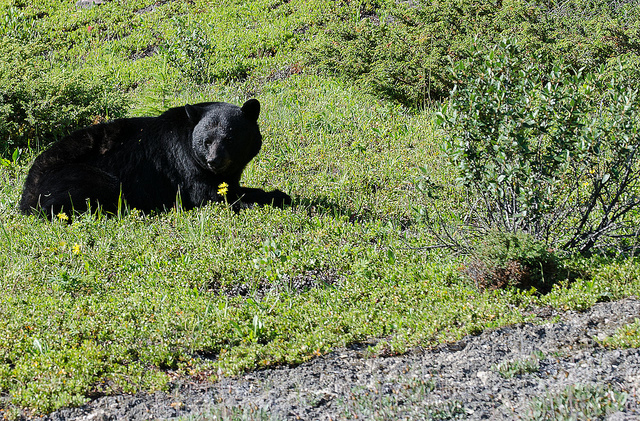

In [50]:
import pathlib

data_train = pathlib.Path('/home/maciek/Documents/ID2223/lab2/datasets/train2014')
train_img_count = len(list(data_train.glob('*.jpg')))
print(train_img_count)

data_val = pathlib.Path('/home/maciek/Documents/ID2223/lab2/datasets/val2014')
val_img_count = len(list(data_val.glob('*.jpg')))
print(val_img_count)

data_test = pathlib.Path('/home/maciek/Documents/ID2223/lab2/datasets/test2014')
test_img_count = len(list(data_test.glob('*.jpg')))
print(test_img_count)

from PIL import Image
import IPython.display as display

pics = list(data_train.glob('*'))
print(pics[:3])

display.display(Image.open(str(pics[len(pics)-3])))


In [45]:
import coco

ModuleNotFoundError: No module named 'coco'

In [64]:
import json
import os
cwd = os.getcwd()

data_path = cwd + '/datasets/'

annotations_train = cwd + '/datasets/annotations/captions_train2014.json'


with open(annotations_train, 'r') as f:
    annotations = json.load(f)
    
all_captions = []
all_imgs = []

for annot in annotations:
    caption = '<start>' + annot['caption'] + '<end>'
    img_id = annot['image_id']
    img_path = data_path + 'train2014' + 'COCO_train2014_' + '%012d.jpg' % (img_id)
    
    all_captions.append(caption)
    all_imgs.append(img_path)
    
print(all_captions[:5])
print(all_imgs[:5])

TypeError: string indices must be integers

In [59]:
PATH

NameError: name 'PATH' is not defined